rpm_max =  324.6760839074665
continuous model
a =  [[-34.48275862]]
b =  [[586.20689655]]



<Figure size 640x480 with 0 Axes>

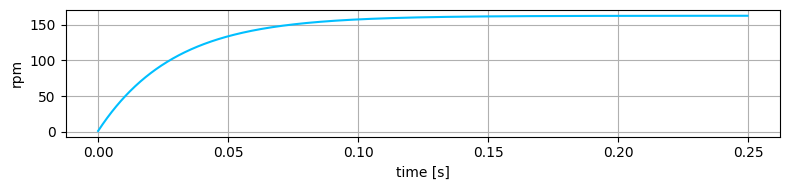

In [16]:
import LibsControl
import numpy
import matplotlib.pyplot as plt

#sampling frequency, 4kHz
dt       = 1.0/4000.0   

# create 1st order demo system
u_max       = 2.0     # max control input value
k           = 17.0    # motor constant 
tau         = 29.0    # motor time constant, milliseconds

rpm_max = u_max*k*60.0/(2.0*numpy.pi)

print("rpm_max = ", rpm_max)

#continuous time dynamics
mat_a = numpy.zeros((1, 1))
mat_b = numpy.zeros((1, 1))
mat_c = numpy.eye(1)
 
tau = tau*0.001
mat_a[0][0] = -1.0/tau    
mat_b[0][0] = k*(1.0/tau)


print("continuous model")
print("a = ", mat_a)
print("b = ", mat_b)
print()

#create dynamical system
ds = LibsControl.DynamicalSystem(mat_a, mat_b, mat_c, dt)


#compute step response
t_result = []
u_result = []
x_result = []

ds.reset()

for n in range(1000):

    # unit step as input
    u = numpy.ones((1, 1))

    x, _ = ds.forward_state(u)

    t_result.append(n*dt)
    x_result.append(x[:, 0])

t_result = numpy.array(t_result)
x_result = numpy.array(x_result)

#plot result
LibsControl.plot_open_loop_response(t_result, x_result*60.0/(2.0*numpy.pi), file_name = "step_response.png", labels = ["rpm"])




0.2 16.9589297220198
0.4 16.979476371018077
0.6 16.986317582062494
0.8 16.989738186547058
1.0 16.991790549237653
1.2 16.993158791031377
1.4 16.994136106598322
1.6 16.994869093273532
1.8 16.995439194020918
2.0 16.995895274618828
k_mean =  16.995895274618828


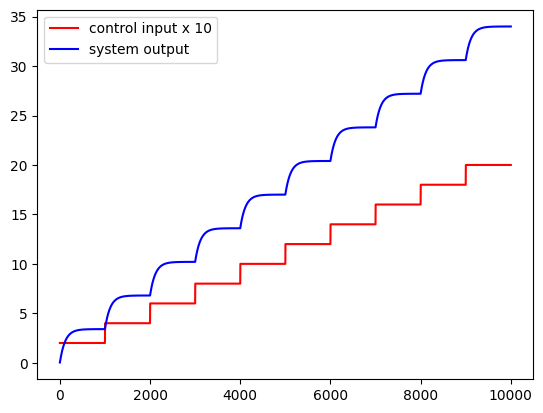

In [17]:
# motor constant k estimation
# we measure motor steady state output on different input levels

# input levels
u_values = u_max*numpy.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

# reset dynamical system into zero state
ds.reset()

u_result = []
x_result = []

for j in range(len(u_values)):

    x_mean = []
    for i in range(1000):

        # convert scalar u to column vector
        u    = u_values[j]
        u    = numpy.array([[u]])
        
        # compute dynamical system one step
        x, _ = ds.forward_state(u)

        # after steady state, store x
        if i > 500:
            x_mean.append(x[0][0])

        # store for plotting
        u_result.append(u[0, 0])
        x_result.append(x[0, 0])


    x_mean = numpy.array(x_mean)
    x_mean = x_mean.mean()

    k_est = x_mean/u_values[j]

    print(u_values[j], k_est)

k_mean = k_est.mean()

# average k estimate
print("k_mean = ", k_mean)


# plot response
u_result = numpy.array(u_result)
x_result = numpy.array(x_result)

plt.plot(10*u_result, label = "control input x 10", color = "red")
plt.plot(x_result, label = "system output", color="blue")
plt.legend(loc="upper left")

periods =  14.5
tau     =  27.44 [ms]

a_est =  -36.44247478164159
b_est =  619.3724849367181


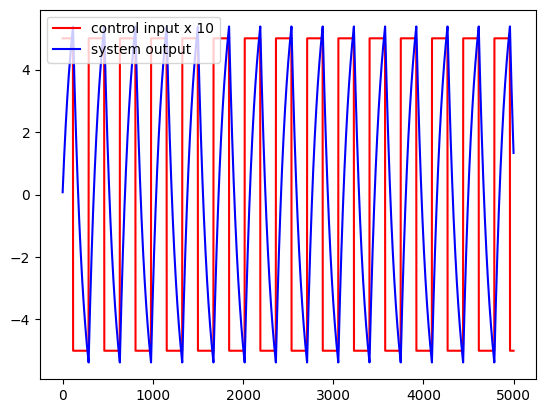

In [18]:
# estimate motor time constant, by bringing system into resonance

u_in    = 0.25*u_max
periods = 0

ds.reset()

u_result = []
x_result = []

n_steps = 5000

for n in range(n_steps):


    # convert scalar u to column vector
    u    = numpy.array([[u_in]])
    
    # compute dynamical system one step
    x, _ = ds.forward_state(u)

    x = x[0][0]

    if u_in > 0.0:
        if x > 0.632*k_mean*u_in:
            u_in = -u_in
            periods+= 1
    else:
        if x < 0.632*k_mean*u_in:
            u_in = -u_in
            periods+= 1
    
    u_result.append(u_in)
    x_result.append(x)
    

# plot response
u_result = numpy.array(u_result)
x_result = numpy.array(x_result)

plt.plot(10*u_result, label = "control input x 10", color = "red")
plt.plot(x_result, label = "system output", color="blue")
plt.legend(loc="upper left")


tau_est = (dt*2*n_steps/periods)/numpy.pi
print("periods = ", periods/2)
print("tau     = ", round(1000*tau_est, 2), "[ms]\n")


a_est = -1.0/tau_est    
b_est = k_mean*(1.0/tau_est)

print("a_est = ", a_est)
print("b_est = ", b_est)